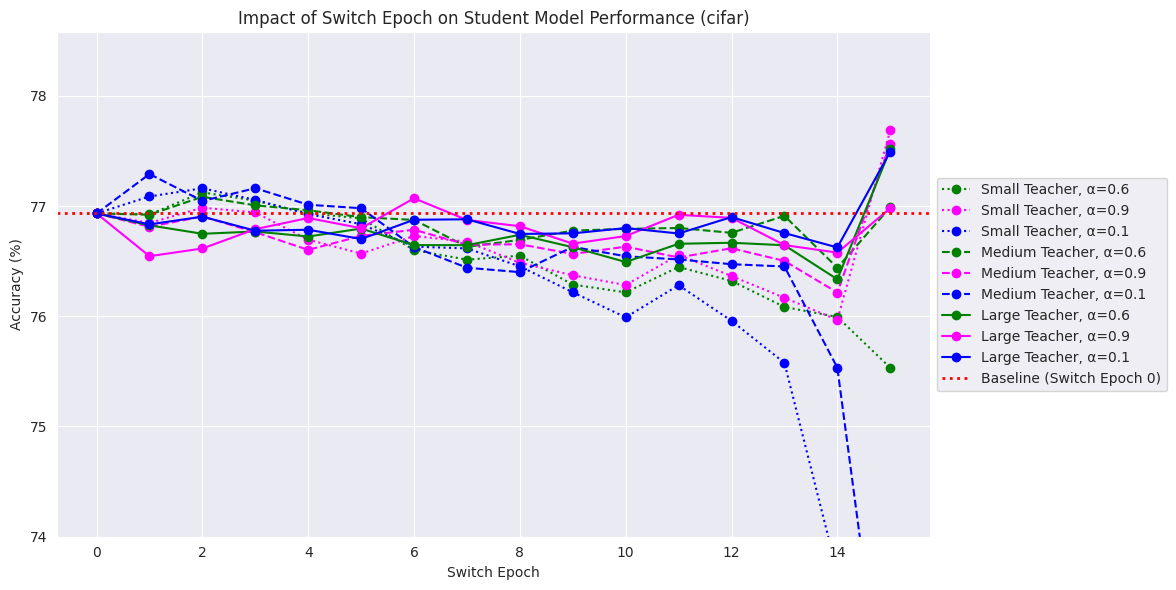

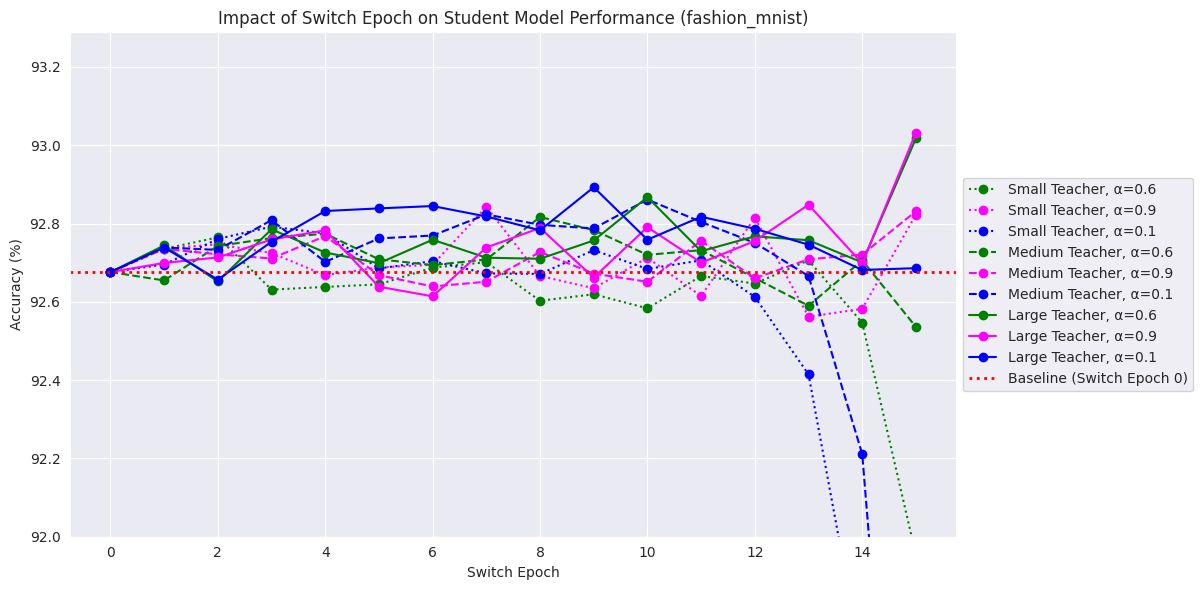

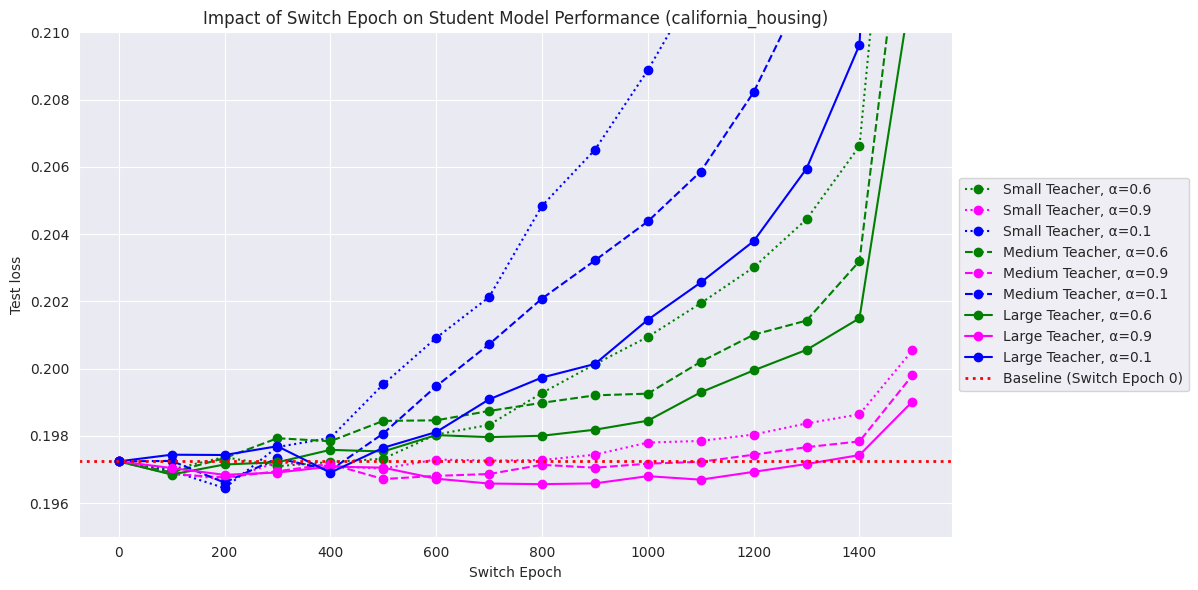

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import re
from collections import defaultdict

output_dir = "../outputs"
seeds = np.loadtxt("../scripts/configs/seeds.txt", dtype=int).tolist()

# Stylování
alpha_colors = {
    "0_1": "blue",
    "0_6": "green",
    "0_9": "magenta"
}
teacher_styles = {
    "small": "dotted",
    "medium": "dashed",
    "large": "solid"
}

experiment_dirs = [d for d in os.listdir(output_dir) if d.startswith("experiment")]
experiment_dirs = sorted(experiment_dirs, key=lambda x: int(re.search(r'experiment(\d+)', x).group(1)))

datasets = "cifar", "fashion_mnist", "california_housing"

for dataset in datasets:
    results = {}
    baselines = []
    
    for exp_dir in experiment_dirs:
        if f"{dataset}" not in exp_dir:
            continue
        
        match = re.match(rf"experiment\d+_alpha_(\d_\d)_(\w+)_{dataset}", exp_dir)
        if not match:
            continue
        
        alpha, teacher_size = match.groups()
        label = f"{teacher_size.capitalize()} Teacher, α={alpha.replace('_', '.')}"
        path = os.path.join(output_dir, exp_dir)
        
        switch_epoch_accuracies = defaultdict(list)
        
        for seed in seeds:
            # switch epoch 0 (student bez distillation)
            student_path = f"{output_dir}/student_{dataset}/model_seed_{seed}/accuracy.txt"
            if os.path.exists(student_path):
                try:
                    acc = np.loadtxt(student_path)
                    switch_epoch_accuracies[0].append(acc)
                except:
                    continue
            
            if dataset == "california_housing":
                switch_epochs = range(100, 1600, 100)  # 100, 200, ..., 1500
            else:
                switch_epochs = range(1, 16)  # 1 to 15
            
            for switch_epoch in switch_epochs:
                switch_path = os.path.join(path, f"seed_{seed}", f"switch_epoch_{switch_epoch}")
                acc_file = os.path.join(switch_path, "accuracy.txt")
                if os.path.exists(acc_file):
                    try:
                        acc = np.loadtxt(acc_file)
                        switch_epoch_accuracies[switch_epoch].append(acc)
                    except:
                        print(f"File not found: {acc_file}")
                        continue
    
        x_vals = sorted(switch_epoch_accuracies.keys())
        y_vals = [np.mean(switch_epoch_accuracies[epoch]) for epoch in x_vals]
        
        # Uložit baseline pro červenou čáru
        if 0 in switch_epoch_accuracies:
            baselines.extend(switch_epoch_accuracies[0])
        
        color = alpha_colors.get(alpha, "black")
        linestyle = teacher_styles.get(teacher_size, "solid")
        results[label] = (x_vals, y_vals, color, linestyle)
    
    # Vykreslení grafu
    plt.figure(figsize=(12, 6))
    for label, (x, y, color, linestyle) in results.items():
        plt.plot(x, y, label=label, color=color, linestyle=linestyle, marker='o')
    
    # Červená baseline čára
    if baselines:
        baseline_mean = np.mean(baselines)
        plt.axhline(y=baseline_mean, color='red', linestyle='dotted', linewidth=2, label='Baseline (Switch Epoch 0)')
    
    plt.title(f"Impact of Switch Epoch on Student Model Performance ({dataset})")
    plt.xlabel("Switch Epoch")
    if dataset == "california_housing":
        plt.ylabel("Test loss")
    else:
        plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if dataset == "cifar":
        plt.ylim(74.0)
    elif dataset == "fashion_mnist":
        plt.ylim(92.0)
    elif dataset == "california_housing":
        plt.ylim(0.195,0.21)
    save_path = dataset + "_accuracy_summary.pdf"
    plt.savefig(f"../graphs/summary/{save_path}", bbox_inches='tight')
    plt.show()


Baseline student accuracy: 76.9327 %


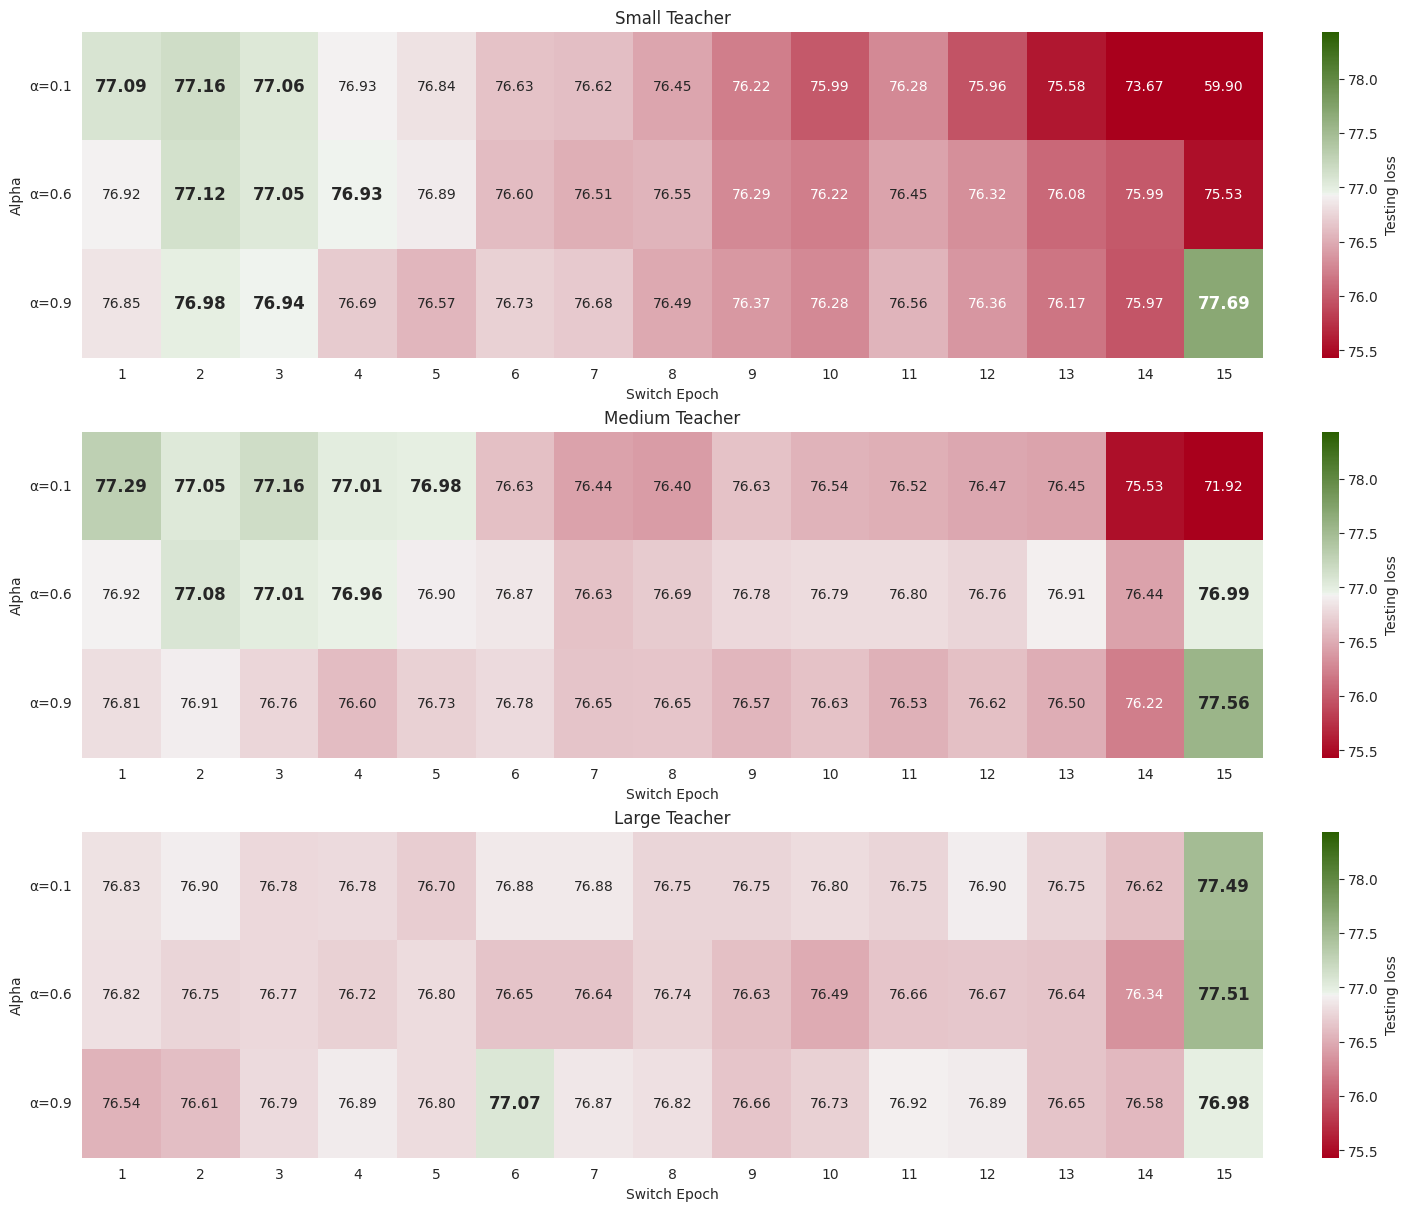

Baseline student accuracy: 92.6760 %


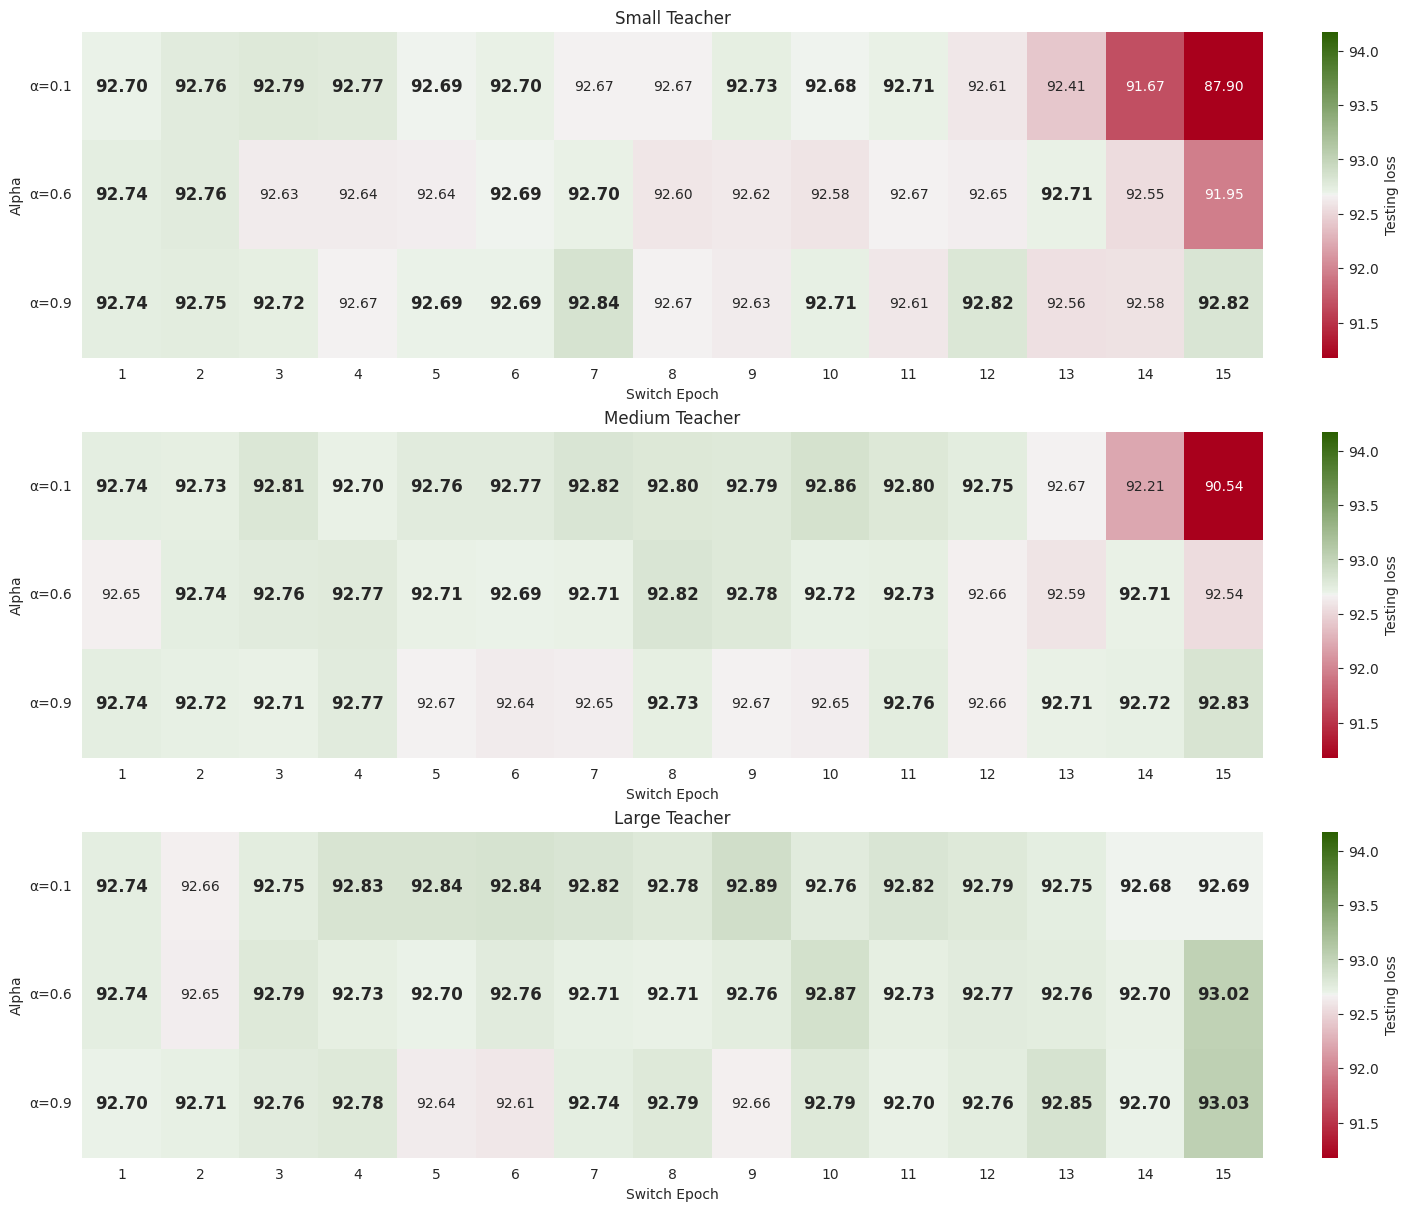

Baseline student accuracy: 0.1972 %


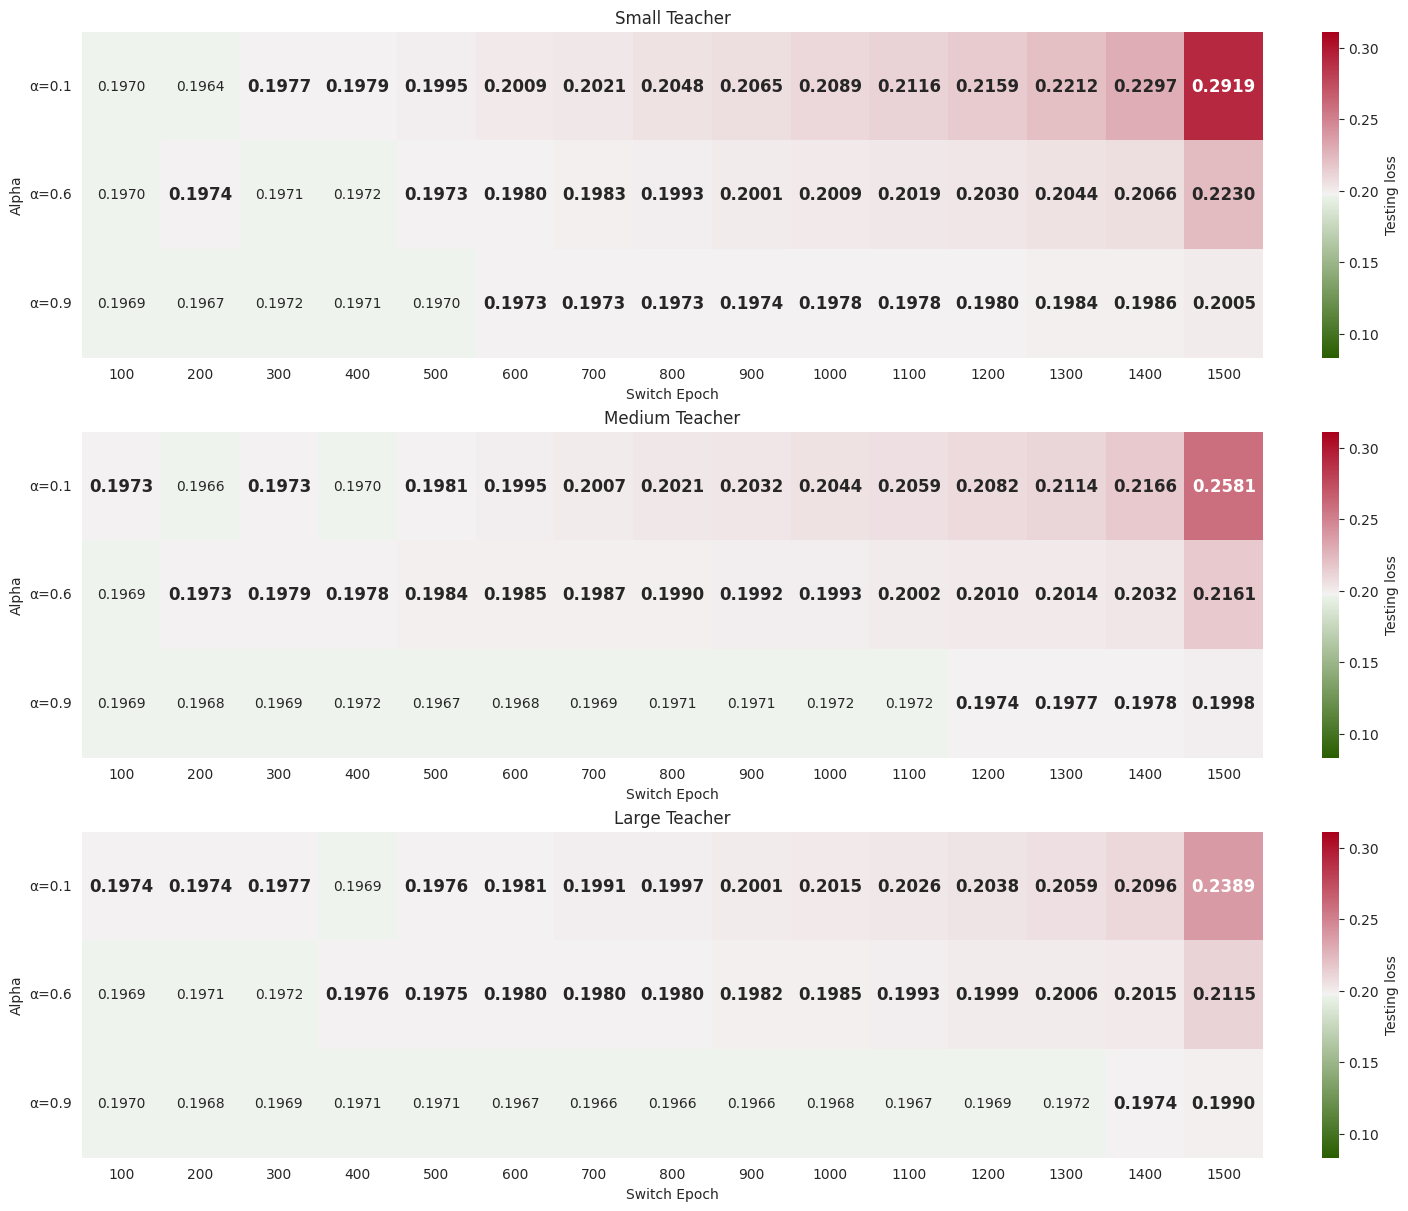

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from matplotlib.colors import TwoSlopeNorm

output_dir = "../outputs"
seeds = np.loadtxt("../scripts/configs/seeds.txt", dtype=int).tolist()

experiment_dirs = [d for d in os.listdir(output_dir) if d.startswith("experiment")]
experiment_dirs = sorted(experiment_dirs, key=lambda x: int(re.search(r'experiment(\d+)', x).group(1)))

datasets = "cifar", "fashion_mnist", "california_housing"

for dataset in datasets:
    results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

    # Načti data
    for exp_dir in experiment_dirs:
        if f"{dataset}" not in exp_dir:
            continue

        match = re.match(fr"experiment\d+_alpha_(\d_\d)_(\w+)_{dataset}", exp_dir)
        if not match:
            continue

        alpha, teacher_size = match.groups()
        path = os.path.join(output_dir, exp_dir)

        for seed in seeds:
            if dataset == "california_housing":
                switch_epochs = range(100, 1600, 100)  # 100, 200, ..., 1500
            else:
                switch_epochs = range(1, 16)  # 1 to 15
            for switch_epoch in switch_epochs:
                acc_path = os.path.join(path, f"seed_{seed}", f"switch_epoch_{switch_epoch}", "accuracy.txt")
                if os.path.exists(acc_path):
                    try:
                        acc = np.loadtxt(acc_path)
                        results[teacher_size][alpha][switch_epoch].append(acc)
                    except:
                        continue

    # Načti baseline accuracy studenta bez distilace
    student_accs = []
    for seed in seeds:
        student_path = f"../outputs/student_{dataset}/model_seed_{seed}/accuracy.txt"
        if os.path.exists(student_path):
            try:
                acc = np.loadtxt(student_path)
                student_accs.append(acc)
            except:
                continue
    baseline_student_acc = np.mean(student_accs)
    print(f"Baseline student accuracy: {baseline_student_acc:.4f} %")

    # Rozsah pro barvy (všechna data dohromady)
    all_accs = []
    for teacher_size in ["small", "medium", "large"]:
        for alpha in ["0_1", "0_6", "0_9"]:
            if dataset == "california_housing":
                switch_epochs = range(100, 1600, 100)  # 100, 200, ..., 1500
            else:
                switch_epochs = range(1, 16)  # 1 to 15
            for epoch in switch_epochs:
                all_accs.extend(results[teacher_size][alpha][epoch])
    diff = np.abs(np.array(all_accs) - baseline_student_acc)
    max_diff = min(np.max(diff), 1.5)
    vmin = baseline_student_acc - max_diff
    vmax = baseline_student_acc + max_diff
    norm = TwoSlopeNorm(vmin=vmin, vcenter=baseline_student_acc, vmax=vmax)

    alpha_labels = ["α=0.1", "α=0.6", "α=0.9"]
    if dataset == "california_housing":
        switch_epochs_range = range(100, 1600, 100)  # 100, 200, ..., 1500
    else:
        switch_epochs_range = range(1, 16)  # 1 to 15
    switch_epochs = list(switch_epochs_range)
    teacher_sizes = ["small", "medium", "large"]
    
    for teacher_size in teacher_sizes:
        for alpha, alpha_label in zip(["0_1", "0_6", "0_9"], alpha_labels):
            row = [alpha_label]
            for epoch in switch_epochs:
                accs = results[teacher_size][alpha][epoch]
                if accs:
                    mean_acc = np.mean(accs)
                    cell = f"{mean_acc:.4f}"
                    # Tučně pokud lepší než baseline
                    if mean_acc > baseline_student_acc:
                        cell = f"*{cell}*"
                else:
                    cell = "   -    "
                row.append(cell)

    # Vykreslení do jednoho obrázku
    fig, axs = plt.subplots(nrows=3, figsize=(14, 12), constrained_layout=True)

    for i, teacher_size in enumerate(teacher_sizes):
        heat_data = []
        font_styles = []

        for alpha in ["0_1", "0_6", "0_9"]:
            row = []
            row_fonts = []
            for epoch in switch_epochs:
                accs = results[teacher_size][alpha][epoch]
                mean_acc = np.mean(accs) if accs else np.nan
                row.append(mean_acc)

                # Styl písma
                if not np.isnan(mean_acc) and mean_acc > baseline_student_acc:
                    row_fonts.append({'weight': 'bold', 'size': 'large'})
                else:
                    row_fonts.append({'weight': 'normal', 'size': 'medium'})
            heat_data.append(row)
            font_styles.append(row_fonts)

        heat_array = np.array(heat_data)
        ax = axs[i]

        sns.heatmap(
            heat_array,
            annot=True,
            fmt = ".4f" if dataset == "california_housing" else ".2f",
            cmap= sns.diverging_palette(120, 10, s=100, l=35, as_cmap=True) if dataset == "california_housing" else sns.diverging_palette(10, 120, s=100, l=35, as_cmap=True),
            norm=norm,
            ax=ax,
            yticklabels=alpha_labels,
            cbar_kws={'label': 'Testing loss'},
            annot_kws={"fontsize": 10}
        )

        for y in range(len(font_styles)):
            for x in range(len(font_styles[y])):
                text = ax.texts[y * len(switch_epochs) + x]
                style = font_styles[y][x]
                text.set_fontweight(style['weight'])
                text.set_fontsize(style['size'])

        ax.set_xticks(np.arange(len(switch_epochs)) + 0.5)
        ax.set_xticklabels(switch_epochs)
        ax.set_yticklabels(alpha_labels, rotation=0)
        ax.set_xlabel("Switch Epoch")
        ax.set_ylabel("Alpha")
        ax.set_title(f"{teacher_size.capitalize()} Teacher")

    #fig.suptitle(f"Average Accuracy Heatmaps ({dataset})", fontsize=16)
    plt.savefig(f"../graphs/summary/heatmaps_{dataset}.pdf")
    plt.show()


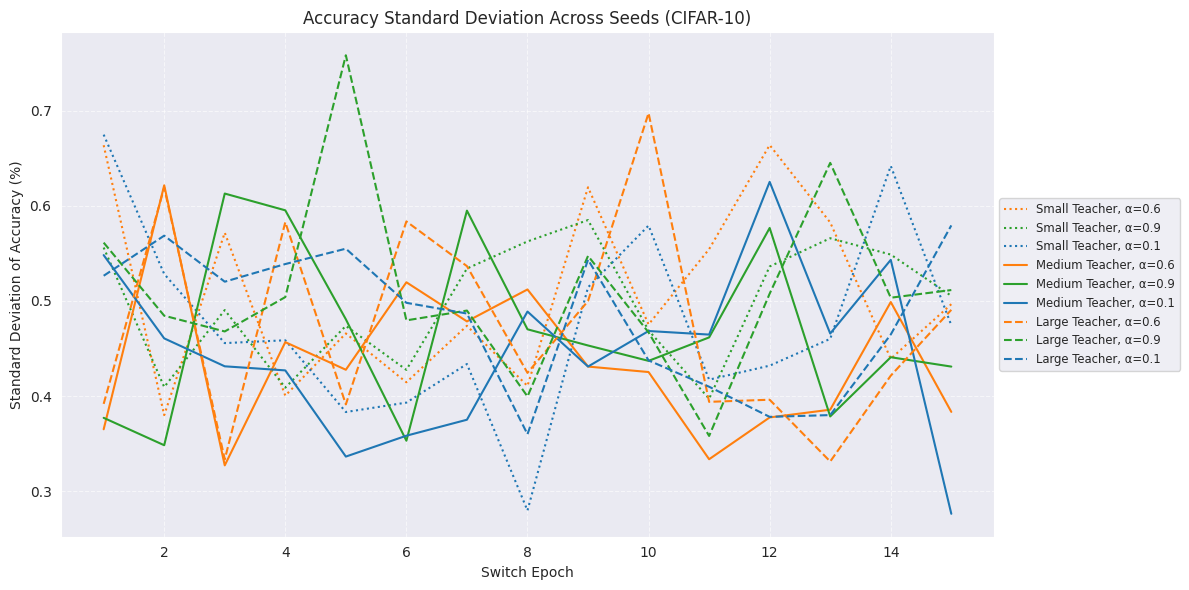

In [3]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict

output_dir = "../outputs"
seeds = np.loadtxt("../scripts/configs/seeds.txt", dtype=int).tolist()

# Barvy pro alphy
alpha_colors = {
    "0_1": "tab:blue",
    "0_6": "tab:orange",
    "0_9": "tab:green"
}

# Styl pro teacher velikost
teacher_styles = {
    "small": "dotted",
    "medium": "solid",
    "large": "dashed"
}

experiment_dirs = [d for d in os.listdir(output_dir) if d.startswith("experiment")]
experiment_dirs = sorted(experiment_dirs, key=lambda x: int(re.search(r'experiment(\d+)', x).group(1)))

plt.figure(figsize=(12, 6))

for exp_dir in experiment_dirs:
    if "cifar" not in exp_dir:
        continue

    match = re.match(r"experiment\d+_alpha_(\d_\d)_(\w+)_cifar", exp_dir)
    if not match:
        continue

    alpha, teacher_size = match.groups()
    path = os.path.join(output_dir, exp_dir)

    switch_epoch_accuracies = defaultdict(list)

    for seed in seeds:
        for switch_epoch in range(1, 17):
            acc_path = os.path.join(path, f"seed_{seed}", f"switch_epoch_{switch_epoch}", "accuracy.txt")
            if os.path.exists(acc_path):
                try:
                    acc = np.loadtxt(acc_path)
                    switch_epoch_accuracies[switch_epoch].append(acc)
                except:
                    continue

    std_devs = []
    switch_epochs = list(range(1, 17))
    for epoch in switch_epochs:
        accs = switch_epoch_accuracies[epoch]
        std = np.std(accs) if accs else np.nan
        std_devs.append(std)

    label = f"{teacher_size.capitalize()} Teacher, α={alpha.replace('_', '.')}"
    plt.plot(switch_epochs, std_devs,
             label=label,
             color=alpha_colors[alpha],
             linestyle=teacher_styles[teacher_size])

# Dokončení grafu
plt.title("Accuracy Standard Deviation Across Seeds (CIFAR-10)")
plt.xlabel("Switch Epoch")
plt.ylabel("Standard Deviation of Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.tight_layout()
plt.show()
